In [1]:
import os
import pickle
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn

In [2]:
from IPython.display import clear_output
from factory.autovc_pytorch_org import AutoVC_ORG
from factory.autovc_pytorch_org_dc import AutoVC_ORG_DC
from factory.autovc_pytorch_metaformer_pool_v2 import AutoVC_MetaFormer_Pool_V2 as AutoVC_MetaFormer_Pool
from factory.autovc_pytorch_metaformer_conv import AutoVC_MetaFormer_Conv
from factory.LstmDV import LstmDV

In [3]:
ROOT = "train_data_en"
device = "cuda:0"

In [4]:
erroment_uttr_idx = 4
max_uttr_idx = 60
num_speaker = 40

In [5]:
#all_speaker = sorted(next(iter(os.walk(f'{ROOT}')))[1],key=int)[:num_speaker]
all_speaker = next(iter(os.walk(f'{ROOT}')))[1][:num_speaker]

In [6]:
# 評估用
C = torch.load('model/static/dv_en_ver2.pt').to(device)

In [7]:
# 要用原本訓練的來生聲音
metadata = pickle.load(open(f'{ROOT}/train.pkl', "rb"))[:num_speaker]

In [8]:
from melgan.interface import *
vocoder = MelVocoder(model_name='model/static/multi_speaker')

In [9]:
org = AutoVC_ORG(44,256,512,22).to(device)
org.load_state_dict(torch.load("model/autovc_pytorch_org_en.pt", map_location=device))

org_dc = AutoVC_ORG_DC(44,256,512,22).to(device)
org_dc.load_state_dict(torch.load("model/autovc_pytorch_org_dc_en.pt", map_location=device))

pool = AutoVC_MetaFormer_Pool(44,256,512,22).to(device) 
pool.load_state_dict(torch.load("model/autovc_pytorch_meta_pool_en.pt", map_location=device))

conv = AutoVC_MetaFormer_Conv(44,256,512,22).to(device) 
conv.load_state_dict(torch.load("model/autovc_pytorch_meta_conv_final_en.pt", map_location=device))

<All keys matched successfully>

In [10]:
def get_trans_mel(model,sample,emb_org,emb_trg):
    return model(sample.to(device),emb_org.to(device),emb_trg.to(device))[1][0,:,:].detach().cpu()

In [11]:
def get_crop_mel(tmp,len_crop=176):
    if tmp.shape[0] < len_crop:
        pad_size = int(len_crop - tmp.shape[0])
        npad = [(0, 0)] * tmp.ndim
        npad[0] = (0, pad_size)
        tmp = np.pad(tmp, pad_width=npad, mode='constant', constant_values=0)
        melsp = torch.from_numpy(tmp)
            
    elif tmp.shape[0] == len_crop:
        melsp = torch.from_numpy(tmp)
    else:
        left = np.random.randint(0, tmp.shape[0] - len_crop)
        melsp = torch.from_numpy(tmp[left : left + len_crop, :])
    return melsp.to(device)

In [12]:
def get_dv(speaker):
    all_uttr = next(iter(os.walk(f'{ROOT}/{speaker}')))[2][:erroment_uttr_idx]
    _dv = torch.zeros((1,256))
    for uttr in all_uttr:
        mel = torch.from_numpy(np.load(f'{ROOT}/{speaker}/{uttr}')).unsqueeze(0).to(device)
        _dv += C(mel)[1].detach().cpu()
    _dv = _dv/(erroment_uttr_idx+1)
    random_uttr = next(iter(os.walk(f'{ROOT}/{speaker}')))[2][random.randint(erroment_uttr_idx,max_uttr_idx)]
    mel = get_crop_mel(np.load(f'{ROOT}/{speaker}/{random_uttr}')).unsqueeze(0)
    emb_org = _dv.to(device) 
    return mel,emb_org,speaker

In [13]:
all_dv = []
for i,speaker in enumerate(all_speaker):
    all_dv.append(get_dv(speaker))

In [14]:
len(all_dv) 

40

In [15]:
def get_cos_rc(cos_res):
    rc = 0.0
    rc_ = 0.0
    N = len(cos_res)
    for i in range(N):
        total = sum(cos_res[i][i])
        others = (total - cos_res[i][i][i])/(N-1)
        rc_ += others
        rc += cos_res[i][i][i]
    return rc/N,rc_/N

In [16]:
def get_cos_trans(cos_res):
    trans = []
    trans_ = []
    N = len(cos_res)
    for i in range(N):
        trans_cos = np.sum(np.diagonal(cos_res[i])) - cos_res[i][i][i]
        trans.append(trans_cos / (N-1))
        trans_.append(  (np.sum(cos_res[i]) - np.sum(np.diagonal(cos_res[i]))) / ((N-1)*N))
    
    return sum(trans)/len(trans),sum(trans_)/len(trans_)

In [17]:
cos_reslut_rc_org = np.zeros((num_speaker,num_speaker,num_speaker))
cos_reslut_rc_dc = np.zeros((num_speaker,num_speaker,num_speaker))
cos_reslut_rc_pool = np.zeros((num_speaker,num_speaker,num_speaker))
cos_reslut_rc_conv = np.zeros((num_speaker,num_speaker,num_speaker)) 
temp = None
for i,data in enumerate(metadata):
    sp_s = data[1]
    source_mel = get_crop_mel(np.load(f"{ROOT}//{data[3]}")).unsqueeze(0)
    emb_org = torch.from_numpy(data[2]).unsqueeze(0)
    print(f"Now Processing --- {sp_s}")
    for j,data in enumerate(metadata):
        sp_o = data[1]
        emb_trg = torch.from_numpy(data[2]).unsqueeze(0)
        trans_mel_org = get_trans_mel(org,source_mel,emb_org,emb_trg).to(device)
        trans_mel_dc = get_trans_mel(org_dc,source_mel,emb_org,emb_trg).to(device)
        trans_mel_pool = get_trans_mel(pool,source_mel,emb_org,emb_trg).to(device)
        trans_mel_conv = get_trans_mel(conv,source_mel,emb_org,emb_trg).to(device)
        org_dv = C(trans_mel_org)[1]
        dc_dv = C(trans_mel_dc)[1]
        pool_dv = C(trans_mel_pool)[1]
        conv_dv = C(trans_mel_conv)[1]
        
        if i==j:
            print(f"Reconstruct ---- {sp_s} to {sp_o}")
        else:
            print(f"Trans --- {sp_s} to {sp_o}")
        
        for k,data in enumerate(all_dv):
            _,emb,_ = data
            cos = torch.clamp(nn.functional.cosine_similarity(org_dv,emb, dim=1, eps=1e-8),min=0.0).detach().cpu().numpy()[0].astype(np.float32)
            cos_reslut_rc_org[i][j][k] = cos
            
            cos = torch.clamp(nn.functional.cosine_similarity(dc_dv,emb, dim=1, eps=1e-8),min=0.0).detach().cpu().numpy()[0].astype(np.float32)
            cos_reslut_rc_dc[i][j][k] = cos
            cos = torch.clamp(nn.functional.cosine_similarity(pool_dv,emb, dim=1, eps=1e-8),min=0.0).detach().cpu().numpy()[0].astype(np.float32)
            cos_reslut_rc_pool[i][j][k] = cos
            cos = torch.clamp(nn.functional.cosine_similarity(conv_dv,emb, dim=1, eps=1e-8),min=0.0).detach().cpu().numpy()[0].astype(np.float32)
            cos_reslut_rc_conv[i][j][k] = cos

Now Processing --- 0
Reconstruct ---- 0 to 0
Trans --- 0 to 1
Trans --- 0 to 2
Trans --- 0 to 3
Trans --- 0 to 4
Trans --- 0 to 5
Trans --- 0 to 6
Trans --- 0 to 7
Trans --- 0 to 8
Trans --- 0 to 9
Trans --- 0 to 10
Trans --- 0 to 11
Trans --- 0 to 12
Trans --- 0 to 13
Trans --- 0 to 14
Trans --- 0 to 15
Trans --- 0 to 16
Trans --- 0 to 17
Trans --- 0 to 18
Trans --- 0 to 19
Trans --- 0 to 20
Trans --- 0 to 21
Trans --- 0 to 22
Trans --- 0 to 23
Trans --- 0 to 24
Trans --- 0 to 25
Trans --- 0 to 26
Trans --- 0 to 27
Trans --- 0 to 28
Trans --- 0 to 29
Trans --- 0 to 30
Trans --- 0 to 31
Trans --- 0 to 32
Trans --- 0 to 33
Trans --- 0 to 34
Trans --- 0 to 35
Trans --- 0 to 36
Trans --- 0 to 37
Trans --- 0 to 38
Trans --- 0 to 39
Now Processing --- 1
Trans --- 1 to 0
Reconstruct ---- 1 to 1
Trans --- 1 to 2
Trans --- 1 to 3
Trans --- 1 to 4
Trans --- 1 to 5
Trans --- 1 to 6
Trans --- 1 to 7
Trans --- 1 to 8
Trans --- 1 to 9
Trans --- 1 to 10
Trans --- 1 to 11
Trans --- 1 to 12
Trans --- 

## Ground Truth

In [18]:
cos_gt = np.zeros((num_speaker,num_speaker))
for i,speaker in enumerate(all_speaker):
    mel,_,_ = get_dv(speaker)
    _dv = C(mel)[1].detach().cpu()
    for j,data in enumerate(all_dv):
        dv = data[1].detach().cpu()
        cos = torch.clamp(nn.functional.cosine_similarity(_dv,dv, dim=1, eps=1e-8),min=0.0).detach().cpu().numpy()[0].astype(np.float32)
        cos_gt[i][j] = cos
np.diagonal(cos_gt).mean(), (np.sum(cos_gt) - (np.sum(np.diagonal(cos_gt)))) /(num_speaker*(num_speaker-1))

(0.9419758155941963, 0.7453862409179027)

## Reconstruct

In [19]:
get_cos_rc(cos_reslut_rc_org)

(0.8559093460440635, 0.7501573295165331)

In [20]:
get_cos_rc(cos_reslut_rc_dc)

(0.9415752917528153, 0.7364096090579644)

In [21]:
get_cos_rc(cos_reslut_rc_pool)

(0.8874414339661598, 0.754773928435185)

In [22]:
get_cos_rc(cos_reslut_rc_conv)

(0.9107288926839828, 0.7516077811519305)

## Trans

In [23]:
get_cos_trans(cos_reslut_rc_org)

(0.8131534179433799, 0.7619033628893204)

In [24]:
get_cos_trans(cos_reslut_rc_dc)

(0.7699133168619413, 0.7532371386336402)

In [25]:
get_cos_trans(cos_reslut_rc_pool)

(0.8535673678876499, 0.7577147164315178)

In [26]:
get_cos_trans(cos_reslut_rc_conv)

(0.8620887708014404, 0.767878712205073)

In [27]:
test = cos_reslut_rc_conv[0][:5,:5]
test.shape

(5, 5)

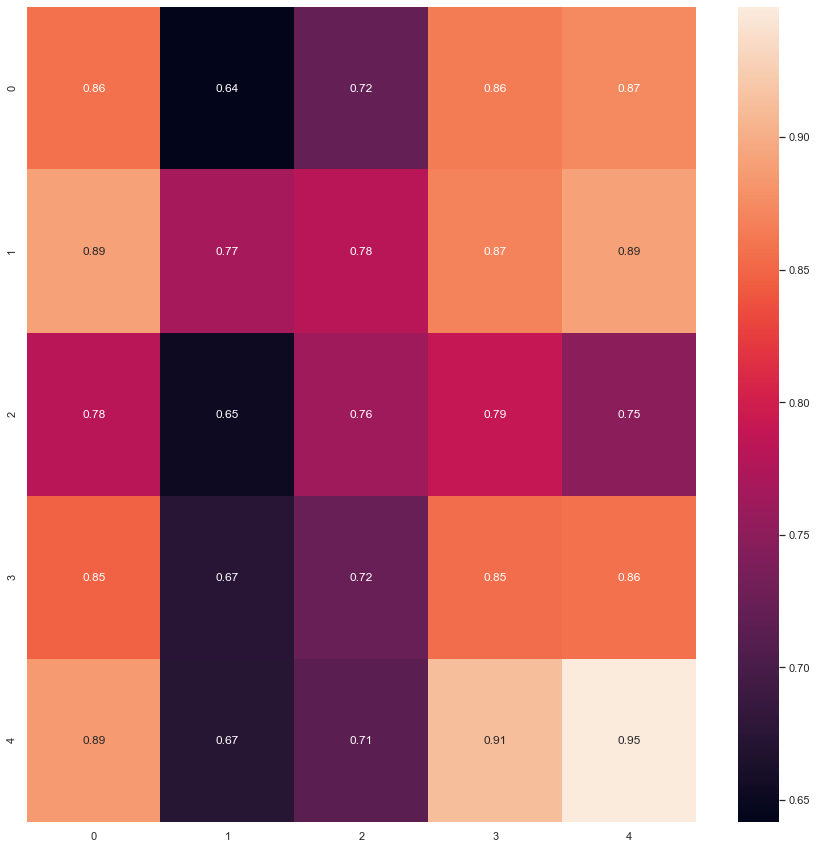

In [28]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(cos_reslut_rc_org[0][:5,:5], annot=True)

## Cos thresholds

In [29]:
thresholds = np.arange(0,1.01,0.01).astype(np.float32)

In [54]:
threshold = 0.7

In [63]:
def get_recall(cos_result,threshold=0.8):
    TP = 0.0
    FN = 0.0
    for cos_res in cos_result:
        trans_ = np.diagonal(cos_res)
        for trans in trans_:
 
            else:
                FN += 1
    return (TP/(TP+FN))

In [68]:
def get_precision(cos_result,threshold=0.8):
    TP = 0.0
    FP = 0.0
    for i,cos_res in enumerate(cos_result):
        for j,cos in enumerate(cos_res):
            if i == j:
                if cos[j] >= threshold:
                    TP += 1
            else:
                if cos[j] >= threshold:
                    FP += 1
    return (TP/(TP+FP))

In [69]:
get_recall(cos_reslut_rc_org,threshold),get_precision(cos_reslut_rc_org,threshold)

(0.79625, 0.027472527472527472)

In [57]:
get_recall(cos_reslut_rc_dc,threshold),

0.714375

In [58]:
get_recall(cos_reslut_rc_pool,threshold),

0.891875

In [59]:
get_recall(cos_reslut_rc_conv,threshold),

0.91875